<a href="https://colab.research.google.com/github/Doradux/IABD-Course/blob/main/PIA%20/tarea_con_redes_neuronales_recurrentes/finances2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

In [2]:
ibex = yf.Ticker("^IBEX")
data = ibex.history(period="5y")
data.to_csv("ibex_1y.csv")

In [3]:
df = pd.read_csv("ibex_1y.csv", index_col="Date", parse_dates=True)
df.index = pd.to_datetime(df.index, utc=True)
df.index = df.index.tz_convert(None)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-03-30 22:00:00,6746.799805,6802.000000,6624.700195,6785.399902,258181200,0.0,0.0
2020-03-31 22:00:00,6627.299805,6687.799805,6565.200195,6579.399902,235113700,0.0,0.0
2020-04-01 22:00:00,6633.700195,6658.899902,6424.500000,6574.100098,233309800,0.0,0.0
2020-04-02 22:00:00,6563.600098,6632.500000,6509.399902,6581.600098,215387500,0.0,0.0
2020-04-05 22:00:00,6807.899902,6874.899902,6728.600098,6844.299805,225965400,0.0,0.0


In [4]:
df.isna().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0
Dividends,0
Stock Splits,0


In [5]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1281.000000,1281.000000,1281.000000,1281.000000,1.281000e+03,1281.0,1281.0
mean,9176.677978,9236.299774,9116.189471,9179.517712,1.748588e+08,0.0,0.0
std,1512.026282,1513.828646,1516.438089,1517.267878,8.842890e+07,0.0,0.0
min,6351.399902,6461.600098,6329.500000,6411.799805,3.048230e+07,0.0,0.0
25%,8201.200195,8259.900391,8134.100098,8194.299805,1.202729e+08,0.0,0.0
50%,8923.700195,8963.700195,8853.900391,8907.599609,1.545438e+08,0.0,0.0
75%,9987.799805,10024.299805,9928.599609,10001.299805,2.038544e+08,0.0,0.0
max,13484.900391,13515.099609,13414.299805,13484.299805,9.752120e+08,0.0,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1281 entries, 2020-03-30 22:00:00 to 2025-03-30 22:00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1281 non-null   float64
 1   High          1281 non-null   float64
 2   Low           1281 non-null   float64
 3   Close         1281 non-null   float64
 4   Volume        1281 non-null   int64  
 5   Dividends     1281 non-null   float64
 6   Stock Splits  1281 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 80.1 KB


In [7]:
start_date = df.index.min()
end_date = df.index.max()
print("Desde:", start_date, "hasta:", end_date)

Desde: 2020-03-30 22:00:00 hasta: 2025-03-30 22:00:00


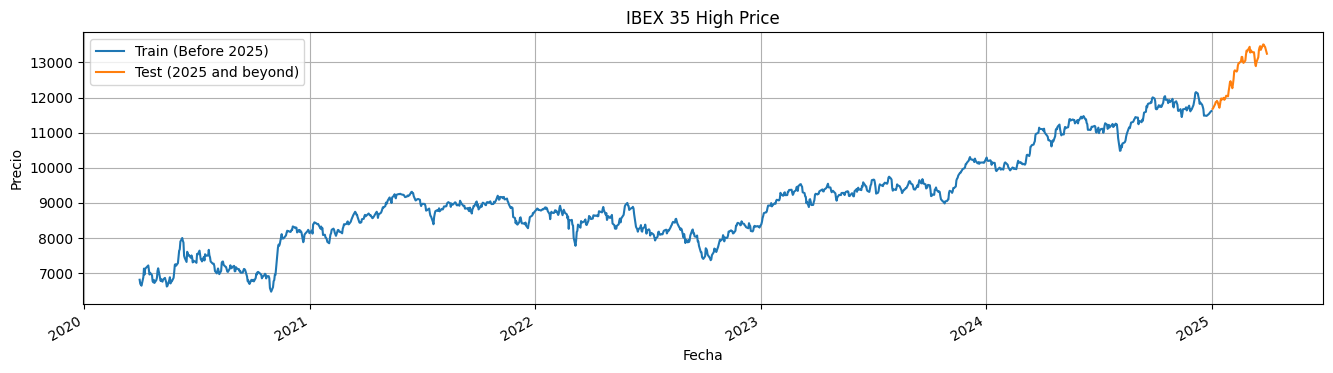

In [8]:
df.index = pd.to_datetime(df.index)
df.index = df.index.tz_localize(None)

tstart = 2020
tend = 2024

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("IBEX 35 High Price")
    plt.xlabel("Fecha")
    plt.ylabel("Precio")
    plt.grid(True)
    plt.show()

train_test_plot(df, tstart, tend)


In [9]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test
training_set, test_set = train_test_split(df, tstart, tend)

In [10]:
sc = MinMaxScaler(feature_range=(0, 1))
# Hacer el reshape es necesario porque MinMaxScaler
# espera una entrada en forma de columnas, donde cada fila representa una muestra y cada columna una característica.
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [11]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 60
features = 1
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [12]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], features)
print(X_train.shape)

(1158, 60, 1)


In [13]:
X_train

array([[[0.05980322],
        [0.03973994],
        [0.03466265],
        ...,
        [0.18157064],
        [0.17204847],
        [0.14655653]],

       [[0.03973994],
        [0.03466265],
        [0.03002458],
        ...,
        [0.17204847],
        [0.14655653],
        [0.15518269]],

       [[0.03466265],
        [0.03002458],
        [0.07261065],
        ...,
        [0.14655653],
        [0.15518269],
        [0.15050945]],

       ...,

       [[0.91600498],
        [0.91403727],
        [0.91475768],
        ...,
        [0.88327486],
        [0.8807626 ],
        [0.88265997]],

       [[0.91403727],
        [0.91475768],
        [0.93457494],
        ...,
        [0.8807626 ],
        [0.88265997],
        [0.89072381]],

       [[0.91475768],
        [0.93457494],
        [0.92640558],
        ...,
        [0.88265997],
        [0.89072381],
        [0.90281109]]])

## Modelo LSTM

In [14]:
!pip install scikeras

In [15]:
!pip install -U scikit-learn

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

def build_and_train_model(units, optimizer, batch_size, epochs, n_steps):
    np.random.seed(455)
    tf.random.set_seed(455)

    inputs = keras.Input(shape=(n_steps, features))
    x = layers.LSTM(units=units, activation="tanh")(inputs)
    outputs = layers.Dense(units=1)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=optimizer, loss='mse')
    model.fit(X_train_tmp, y_train_tmp, batch_size=batch_size, epochs=epochs, verbose=0)

    return model


In [17]:
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras import layers

param_grid = {
    'n_steps': [30, 45, 60],
    'units': [50, 100, 125],
    'optimizer': ['adam', 'RMSprop'],
    'batch_size': [16, 32],
    'epochs': [30, 50]
}

best_rmse = float("inf")
best_params = None
best_model = None

combinations = [
    (n, u, o, b, e)
    for n in param_grid['n_steps']
    for u in param_grid['units']
    for o in param_grid['optimizer']
    for b in param_grid['batch_size']
    for e in param_grid['epochs']
]

print(f"\nProbando {len(combinations)} combinaciones...\n")

for i, (n_steps, units, optimizer, batch_size, epochs) in enumerate(combinations, 1):
    print(f"\n{i}/{len(combinations)} - n_steps={n_steps}, units={units}, optimizer={optimizer}, batch_size={batch_size}, epochs={epochs}")

    # Crear nuevas secuencias según el nuevo n_steps
    X_train_tmp, y_train_tmp = split_sequence(training_set_scaled, n_steps)
    X_train_tmp = X_train_tmp.reshape(X_train_tmp.shape[0], X_train_tmp.shape[1], features)

    model = build_and_train_model(units, optimizer, batch_size, epochs, n_steps)  # modificamos esta función
    predictions = model.predict(X_train_tmp, verbose=0)
    rmse = np.sqrt(mean_squared_error(y_train_tmp, predictions))
    print(f"   RMSE: {rmse:.4f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = (n_steps, units, optimizer, batch_size, epochs)
        best_model = model


Probando 72 combinaciones...


1/72 - n_steps=30, units=50, optimizer=adam, batch_size=16, epochs=30
   RMSE: 0.0209

2/72 - n_steps=30, units=50, optimizer=adam, batch_size=16, epochs=50
   RMSE: 0.0179

3/72 - n_steps=30, units=50, optimizer=adam, batch_size=32, epochs=30
   RMSE: 0.0260

4/72 - n_steps=30, units=50, optimizer=adam, batch_size=32, epochs=50
   RMSE: 0.0240

5/72 - n_steps=30, units=50, optimizer=RMSprop, batch_size=16, epochs=30
   RMSE: 0.0205

6/72 - n_steps=30, units=50, optimizer=RMSprop, batch_size=16, epochs=50
   RMSE: 0.0186

7/72 - n_steps=30, units=50, optimizer=RMSprop, batch_size=32, epochs=30
   RMSE: 0.0216

8/72 - n_steps=30, units=50, optimizer=RMSprop, batch_size=32, epochs=50
   RMSE: 0.0206

9/72 - n_steps=30, units=100, optimizer=adam, batch_size=16, epochs=30
   RMSE: 0.0189

10/72 - n_steps=30, units=100, optimizer=adam, batch_size=16, epochs=50
   RMSE: 0.0153

11/72 - n_steps=30, units=100, optimizer=adam, batch_size=32, epochs=30
   RMSE: 0.

In [18]:
# Preparar X_test otra vez si hace falta
dataset_total = df.loc[:, "High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

X_test, y_test = split_sequence(inputs, n_steps)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)

# Predecir con el mejor modelo
predicted_stock_price = best_model.predict(X_test, verbose=0)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


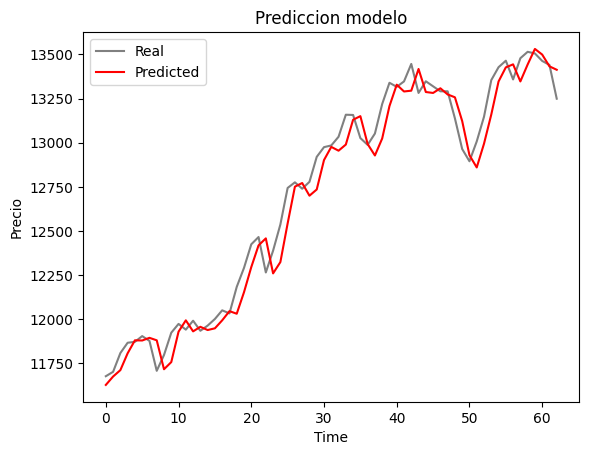

The root mean squared error is 106.02.


In [19]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Prediccion modelo")
    plt.xlabel("Time")
    plt.ylabel("Precio")
    plt.legend()
    plt.show()

def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

# Mostramos los resultados
plot_predictions(test_set, predicted_stock_price)
return_rmse(test_set, predicted_stock_price)


## Modelo GRU

In [20]:
from tensorflow.keras.layers import GRU
from tqdm import tqdm  # mostrar el progreso bonito

def build_and_train_gru_model(units, optimizer, batch_size, epochs, n_steps, X_train_tmp, y_train_tmp):
    np.random.seed(455)
    tf.random.set_seed(455)
    random.seed(455)

    # Definición con API funcional
    inputs = keras.Input(shape=(n_steps, features))
    x = layers.GRU(units=units, activation="tanh")(inputs)
    outputs = layers.Dense(units=1)(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss="mse")
    model.fit(X_train_tmp, y_train_tmp, batch_size=batch_size, epochs=epochs, verbose=0)

    return model


Probando 72 combinaciones...



  0%|          | 0/72 [00:00<?, ?it/s]


1/72 - n_steps=30, units=50, optimizer=adam, batch_size=16, epochs=30


  1%|▏         | 1/72 [00:54<1:04:27, 54.47s/it]

   RMSE: 0.0169

2/72 - n_steps=30, units=50, optimizer=adam, batch_size=16, epochs=50


  3%|▎         | 2/72 [02:05<1:15:12, 64.47s/it]

   RMSE: 0.0151

3/72 - n_steps=30, units=50, optimizer=adam, batch_size=32, epochs=30


  4%|▍         | 3/72 [02:36<56:12, 48.88s/it]  

   RMSE: 0.0194

4/72 - n_steps=30, units=50, optimizer=adam, batch_size=32, epochs=50


  6%|▌         | 4/72 [03:26<55:59, 49.41s/it]

   RMSE: 0.0189

5/72 - n_steps=30, units=50, optimizer=RMSprop, batch_size=16, epochs=30


  7%|▋         | 5/72 [04:09<52:28, 47.00s/it]

   RMSE: 0.0181

6/72 - n_steps=30, units=50, optimizer=RMSprop, batch_size=16, epochs=50


  8%|▊         | 6/72 [05:19<1:00:14, 54.76s/it]

   RMSE: 0.0159

7/72 - n_steps=30, units=50, optimizer=RMSprop, batch_size=32, epochs=30


 10%|▉         | 7/72 [05:48<50:29, 46.61s/it]  

   RMSE: 0.0187

8/72 - n_steps=30, units=50, optimizer=RMSprop, batch_size=32, epochs=50


 11%|█         | 8/72 [06:30<48:08, 45.13s/it]

   RMSE: 0.0173

9/72 - n_steps=30, units=100, optimizer=adam, batch_size=16, epochs=30


 12%|█▎        | 9/72 [07:37<54:24, 51.82s/it]

   RMSE: 0.0162

10/72 - n_steps=30, units=100, optimizer=adam, batch_size=16, epochs=50


 14%|█▍        | 10/72 [09:21<1:10:15, 67.98s/it]

   RMSE: 0.0150

11/72 - n_steps=30, units=100, optimizer=adam, batch_size=32, epochs=30


 15%|█▌        | 11/72 [10:00<1:00:09, 59.17s/it]

   RMSE: 0.0205

12/72 - n_steps=30, units=100, optimizer=adam, batch_size=32, epochs=50


 17%|█▋        | 12/72 [11:08<1:01:41, 61.69s/it]

   RMSE: 0.0173

13/72 - n_steps=30, units=100, optimizer=RMSprop, batch_size=16, epochs=30


 18%|█▊        | 13/72 [12:10<1:00:54, 61.94s/it]

   RMSE: 0.0187

14/72 - n_steps=30, units=100, optimizer=RMSprop, batch_size=16, epochs=50


 19%|█▉        | 14/72 [13:53<1:11:46, 74.25s/it]

   RMSE: 0.0175

15/72 - n_steps=30, units=100, optimizer=RMSprop, batch_size=32, epochs=30


 21%|██        | 15/72 [14:30<1:00:00, 63.17s/it]

   RMSE: 0.0178

16/72 - n_steps=30, units=100, optimizer=RMSprop, batch_size=32, epochs=50


 22%|██▏       | 16/72 [15:31<58:20, 62.51s/it]  

   RMSE: 0.0166

17/72 - n_steps=30, units=125, optimizer=adam, batch_size=16, epochs=30


 24%|██▎       | 17/72 [16:35<57:29, 62.72s/it]

   RMSE: 0.0160

18/72 - n_steps=30, units=125, optimizer=adam, batch_size=16, epochs=50


 25%|██▌       | 18/72 [18:24<1:09:13, 76.91s/it]

   RMSE: 0.0146

19/72 - n_steps=30, units=125, optimizer=adam, batch_size=32, epochs=30


 26%|██▋       | 19/72 [19:08<59:07, 66.92s/it]  

   RMSE: 0.0190

20/72 - n_steps=30, units=125, optimizer=adam, batch_size=32, epochs=50


 28%|██▊       | 20/72 [20:20<59:14, 68.35s/it]

   RMSE: 0.0158

21/72 - n_steps=30, units=125, optimizer=RMSprop, batch_size=16, epochs=30


 29%|██▉       | 21/72 [21:21<56:12, 66.13s/it]

   RMSE: 0.0173

22/72 - n_steps=30, units=125, optimizer=RMSprop, batch_size=16, epochs=50


 31%|███       | 22/72 [23:14<1:06:53, 80.27s/it]

   RMSE: 0.0154

23/72 - n_steps=30, units=125, optimizer=RMSprop, batch_size=32, epochs=30


 32%|███▏      | 23/72 [24:01<57:22, 70.26s/it]  

   RMSE: 0.0176

24/72 - n_steps=30, units=125, optimizer=RMSprop, batch_size=32, epochs=50


 33%|███▎      | 24/72 [25:11<56:04, 70.09s/it]

   RMSE: 0.0165

25/72 - n_steps=45, units=50, optimizer=adam, batch_size=16, epochs=30


 35%|███▍      | 25/72 [26:16<53:43, 68.58s/it]

   RMSE: 0.0165

26/72 - n_steps=45, units=50, optimizer=adam, batch_size=16, epochs=50


 36%|███▌      | 26/72 [28:09<1:02:54, 82.05s/it]

   RMSE: 0.0155

27/72 - n_steps=45, units=50, optimizer=adam, batch_size=32, epochs=30


 38%|███▊      | 27/72 [28:48<51:42, 68.94s/it]  

   RMSE: 0.0181

28/72 - n_steps=45, units=50, optimizer=adam, batch_size=32, epochs=50


 39%|███▉      | 28/72 [29:50<49:06, 66.96s/it]

   RMSE: 0.0170

29/72 - n_steps=45, units=50, optimizer=RMSprop, batch_size=16, epochs=30


 40%|████      | 29/72 [30:52<46:50, 65.36s/it]

   RMSE: 0.0164

30/72 - n_steps=45, units=50, optimizer=RMSprop, batch_size=16, epochs=50


 42%|████▏     | 30/72 [32:41<55:00, 78.59s/it]

   RMSE: 0.0155

31/72 - n_steps=45, units=50, optimizer=RMSprop, batch_size=32, epochs=30


 43%|████▎     | 31/72 [33:23<46:15, 67.70s/it]

   RMSE: 0.0218

32/72 - n_steps=45, units=50, optimizer=RMSprop, batch_size=32, epochs=50


 44%|████▍     | 32/72 [34:28<44:32, 66.81s/it]

   RMSE: 0.0200

33/72 - n_steps=45, units=100, optimizer=adam, batch_size=16, epochs=30


 46%|████▌     | 33/72 [35:55<47:22, 72.87s/it]

   RMSE: 0.0161

34/72 - n_steps=45, units=100, optimizer=adam, batch_size=16, epochs=50


 47%|████▋     | 34/72 [38:02<56:27, 89.15s/it]

   RMSE: 0.0148

35/72 - n_steps=45, units=100, optimizer=adam, batch_size=32, epochs=30


 49%|████▊     | 35/72 [39:02<49:33, 80.36s/it]

   RMSE: 0.0191

36/72 - n_steps=45, units=100, optimizer=adam, batch_size=32, epochs=50


 50%|█████     | 36/72 [40:27<49:00, 81.69s/it]

   RMSE: 0.0171

37/72 - n_steps=45, units=100, optimizer=RMSprop, batch_size=16, epochs=30


 51%|█████▏    | 37/72 [41:43<46:36, 79.91s/it]

   RMSE: 0.0163

38/72 - n_steps=45, units=100, optimizer=RMSprop, batch_size=16, epochs=50


 53%|█████▎    | 38/72 [43:53<53:53, 95.10s/it]

   RMSE: 0.0155

39/72 - n_steps=45, units=100, optimizer=RMSprop, batch_size=32, epochs=30


 54%|█████▍    | 39/72 [44:39<44:16, 80.49s/it]

   RMSE: 0.0235

40/72 - n_steps=45, units=100, optimizer=RMSprop, batch_size=32, epochs=50


 56%|█████▌    | 40/72 [45:57<42:26, 79.57s/it]

   RMSE: 0.0212

41/72 - n_steps=45, units=125, optimizer=adam, batch_size=16, epochs=30


 57%|█████▋    | 41/72 [47:28<42:54, 83.06s/it]

   RMSE: 0.0157

42/72 - n_steps=45, units=125, optimizer=adam, batch_size=16, epochs=50


 58%|█████▊    | 42/72 [50:03<52:16, 104.55s/it]

   RMSE: 0.0145

43/72 - n_steps=45, units=125, optimizer=adam, batch_size=32, epochs=30


 60%|█████▉    | 43/72 [51:20<46:32, 96.30s/it] 

   RMSE: 0.0189

44/72 - n_steps=45, units=125, optimizer=adam, batch_size=32, epochs=50


 61%|██████    | 44/72 [53:13<47:22, 101.50s/it]

   RMSE: 0.0164

45/72 - n_steps=45, units=125, optimizer=RMSprop, batch_size=16, epochs=30


 62%|██████▎   | 45/72 [54:46<44:30, 98.92s/it] 

   RMSE: 0.0162

46/72 - n_steps=45, units=125, optimizer=RMSprop, batch_size=16, epochs=50


 64%|██████▍   | 46/72 [57:15<49:20, 113.86s/it]

   RMSE: 0.0154

47/72 - n_steps=45, units=125, optimizer=RMSprop, batch_size=32, epochs=30


 65%|██████▌   | 47/72 [58:32<42:46, 102.64s/it]

   RMSE: 0.0246

48/72 - n_steps=45, units=125, optimizer=RMSprop, batch_size=32, epochs=50


 67%|██████▋   | 48/72 [1:00:37<43:45, 109.41s/it]

   RMSE: 0.0220

49/72 - n_steps=60, units=50, optimizer=adam, batch_size=16, epochs=30


 68%|██████▊   | 49/72 [1:01:55<38:24, 100.18s/it]

   RMSE: 0.0161

50/72 - n_steps=60, units=50, optimizer=adam, batch_size=16, epochs=50


 69%|██████▉   | 50/72 [1:03:59<39:18, 107.20s/it]

   RMSE: 0.0156

51/72 - n_steps=60, units=50, optimizer=adam, batch_size=32, epochs=30


 71%|███████   | 51/72 [1:04:44<31:02, 88.67s/it] 

   RMSE: 0.0181

52/72 - n_steps=60, units=50, optimizer=adam, batch_size=32, epochs=50


 72%|███████▏  | 52/72 [1:05:58<28:02, 84.10s/it]

   RMSE: 0.0170

53/72 - n_steps=60, units=50, optimizer=RMSprop, batch_size=16, epochs=30


 74%|███████▎  | 53/72 [1:07:31<27:26, 86.68s/it]

   RMSE: 0.0333

54/72 - n_steps=60, units=50, optimizer=RMSprop, batch_size=16, epochs=50


 75%|███████▌  | 54/72 [1:09:58<31:30, 105.02s/it]

   RMSE: 0.0254

55/72 - n_steps=60, units=50, optimizer=RMSprop, batch_size=32, epochs=30


 76%|███████▋  | 55/72 [1:11:04<26:22, 93.09s/it] 

   RMSE: 0.0329

56/72 - n_steps=60, units=50, optimizer=RMSprop, batch_size=32, epochs=50


 78%|███████▊  | 56/72 [1:12:20<23:27, 87.95s/it]

   RMSE: 0.0288

57/72 - n_steps=60, units=100, optimizer=adam, batch_size=16, epochs=30


 79%|███████▉  | 57/72 [1:14:22<24:36, 98.44s/it]

   RMSE: 0.0165

58/72 - n_steps=60, units=100, optimizer=adam, batch_size=16, epochs=50


 81%|████████  | 58/72 [1:17:44<30:10, 129.30s/it]

   RMSE: 0.0147

59/72 - n_steps=60, units=100, optimizer=adam, batch_size=32, epochs=30


 82%|████████▏ | 59/72 [1:18:56<24:16, 112.03s/it]

   RMSE: 0.0180

60/72 - n_steps=60, units=100, optimizer=adam, batch_size=32, epochs=50


 83%|████████▎ | 60/72 [1:20:48<22:27, 112.29s/it]

   RMSE: 0.0167

61/72 - n_steps=60, units=100, optimizer=RMSprop, batch_size=16, epochs=30


 85%|████████▍ | 61/72 [1:22:29<19:55, 108.71s/it]

   RMSE: 0.0283

62/72 - n_steps=60, units=100, optimizer=RMSprop, batch_size=16, epochs=50


 86%|████████▌ | 62/72 [1:25:05<20:29, 122.98s/it]

   RMSE: 0.0244

63/72 - n_steps=60, units=100, optimizer=RMSprop, batch_size=32, epochs=30


 88%|████████▊ | 63/72 [1:26:13<15:57, 106.36s/it]

   RMSE: 0.0337

64/72 - n_steps=60, units=100, optimizer=RMSprop, batch_size=32, epochs=50


 89%|████████▉ | 64/72 [1:28:07<14:31, 108.88s/it]

   RMSE: 0.0290

65/72 - n_steps=60, units=125, optimizer=adam, batch_size=16, epochs=30


 90%|█████████ | 65/72 [1:30:24<13:40, 117.26s/it]

   RMSE: 0.0158

66/72 - n_steps=60, units=125, optimizer=adam, batch_size=16, epochs=50


 92%|█████████▏| 66/72 [1:34:02<14:44, 147.39s/it]

   RMSE: 0.0143

67/72 - n_steps=60, units=125, optimizer=adam, batch_size=32, epochs=30


 93%|█████████▎| 67/72 [1:35:31<10:49, 129.84s/it]

   RMSE: 0.0174

68/72 - n_steps=60, units=125, optimizer=adam, batch_size=32, epochs=50


 94%|█████████▍| 68/72 [1:37:56<08:57, 134.38s/it]

   RMSE: 0.0167

69/72 - n_steps=60, units=125, optimizer=RMSprop, batch_size=16, epochs=30


 96%|█████████▌| 69/72 [1:40:17<06:49, 136.57s/it]

   RMSE: 0.0272

70/72 - n_steps=60, units=125, optimizer=RMSprop, batch_size=16, epochs=50


 97%|█████████▋| 70/72 [1:44:09<05:30, 165.19s/it]

   RMSE: 0.0244

71/72 - n_steps=60, units=125, optimizer=RMSprop, batch_size=32, epochs=30


 99%|█████████▊| 71/72 [1:45:41<02:23, 143.02s/it]

   RMSE: 0.0340

72/72 - n_steps=60, units=125, optimizer=RMSprop, batch_size=32, epochs=50


100%|██████████| 72/72 [1:48:04<00:00, 90.07s/it] 

   RMSE: 0.0291


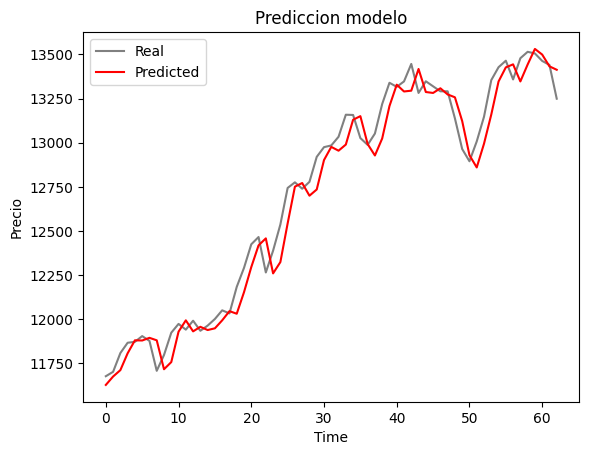

The root mean squared error is 106.02.

Mejores hiperparámetros GRU encontrados:
n_steps=60, units=125, optimizer=adam, batch_size=16, epochs=50


In [22]:
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import random

param_grid = {
    'n_steps': [30, 45, 60],
    'units': [50, 100, 125],
    'optimizer': ['adam', 'RMSprop'],
    'batch_size': [16, 32],
    'epochs': [30, 50]
}

best_rmse = float("inf")
best_params = None
best_model = None

combinations = [
    (n, u, o, b, e)
    for n in param_grid['n_steps']
    for u in param_grid['units']
    for o in param_grid['optimizer']
    for b in param_grid['batch_size']
    for e in param_grid['epochs']
]

print(f"\nProbando {len(combinations)} combinaciones...\n")

for i, (n_steps, units, optimizer, batch_size, epochs) in enumerate(tqdm(combinations), 1):
    print(f"\n{i}/{len(combinations)} - n_steps={n_steps}, units={units}, optimizer={optimizer}, batch_size={batch_size}, epochs={epochs}")

    # Generar nuevas secuencias para cada n_steps
    X_train_tmp, y_train_tmp = split_sequence(training_set_scaled, n_steps)
    X_train_tmp = X_train_tmp.reshape(X_train_tmp.shape[0], X_train_tmp.shape[1], features)

    model = build_and_train_gru_model(units, optimizer, batch_size, epochs, n_steps, X_train_tmp, y_train_tmp)
    predictions = model.predict(X_train_tmp, verbose=0)
    rmse = np.sqrt(mean_squared_error(y_train_tmp, predictions))
    print(f"   RMSE: {rmse:.4f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = (n_steps, units, optimizer, batch_size, epochs)
        best_model = model

plot_predictions(test_set, predicted_stock_price)
return_rmse(test_set, predicted_stock_price)

print("\nMejores hiperparámetros GRU encontrados:")
print(f"n_steps={best_params[0]}, units={best_params[1]}, optimizer={best_params[2]}, batch_size={best_params[3]}, epochs={best_params[4]}")


In [23]:
best_n_steps = best_params[0]

inputs = dataset_total[len(dataset_total) - len(test_set) - best_n_steps:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

X_test, y_test = split_sequence(inputs, best_n_steps)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)


## Usando la API

In [25]:
from tensorflow import keras
from tensorflow.keras import layers
import random

# Semillas fijas para reproducibilidad
np.random.seed(455)
tf.random.set_seed(455)
random.seed(455)

# Mejores hiperparámetros encontrados
best_units = 100
best_optimizer = 'adam'
best_batch_size = 16
best_epochs = 50

# Definir la entrada
inputs = keras.Input(shape=(n_steps, features))

# Capa LSTM
x = layers.LSTM(units=best_units, activation="tanh")(inputs)

# Capa de salida
outputs = layers.Dense(units=1)(x)

# Crear modelo
model_lstm = keras.Model(inputs=inputs, outputs=outputs)

# Compilar modelo
model_lstm.compile(optimizer=best_optimizer, loss="mse")

# Mostrar resumen
model_lstm.summary()

Model: "functional_144"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_144 (InputLayer)         │ (None, 60, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_72 (LSTM)                       │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_144 (Dense)                    │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model_lstm.fit(X_train, y_train, batch_size=best_batch_size, epochs=best_epochs, verbose=1)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0736
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0014
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0012
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0011
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0011
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0011
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0010
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 9.6273e-04
Epoch 9/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 9.1384e-04
Epoch 10/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 8.7072e-04
Epoch 11/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 8.3412e-04
Epoch 12/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 8.0341e-04
Epoch 13/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 7.7703e-04
Epoch 14/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 7.5317e-04
Epoch 15/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 3

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


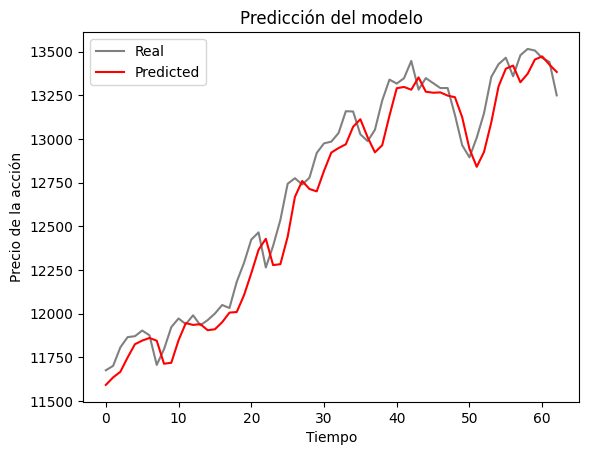

El RMSE (error cuadrático medio) es 129.64


In [27]:
# Predecir
predicted_stock_price = model_lstm.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Mostrar resultados
plot_predictions(test_set, predicted_stock_price)
return_rmse(test_set, predicted_stock_price)